# AWS hosted Services
This is a tutorial to run inference on AWS SageMaker. For a complete example take a look [here](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/products/sagemaker/models/JSL-FormParsing-VLM-3B/JSL-FormParsing-VLM-3B.ipynb)
## 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page [JSL Forms - 3B ](https://aws.amazon.com/marketplace/pp/prodview-52d3gwyawdfge)
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

**Model**: `JSL-Forms-VLM-3B-v1`  
**Model Description**: This model leverages a lightweight Vision-Language Model (VLM) to transform document images into a structured, hierarchical JSON representation. By representing documents as hierarchies, it unlocks a powerful and versatile way to capture layout and meaning in a unified format.

In [9]:
model_package_arn = "arn comes here!"

In [10]:
import os
import io
import base64
import json
import uuid
import requests
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
import boto3
from IPython.display import Image, display
from PIL import Image as ImageEdit
import numpy as np
import pandas as pd
from IPython.display import Image

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

sagemaker_session = sage.Session()
s3_bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role = get_execution_role()

sagemaker = boto3.client("sagemaker")
s3_client = sagemaker_session.boto_session.client("s3")
ecr = boto3.client("ecr")
sm_runtime = boto3.client("sagemaker-runtime")

In [11]:
role

'arn:aws:iam::189352970232:role/service-role/AmazonSageMaker-ExecutionRole-20210428T000922'

In [12]:
model_name = "JSL-Forms-VLM-3B-v1"

real_time_inference_instance_type = "ml.g4dn.12xlarge"
batch_transform_inference_instance_type = "ml.g4dn.12xlarge"

## 2. Create a deployable model from the model package.

In [13]:
model = ModelPackage(
    role=role, 
    model_package_arn=model_package_arn, 
    sagemaker_session=sagemaker_session, 
)

In [14]:
import base64

def encode_file_to_base64(file_path: str) -> str:
    """
    Reads a file from disk and returns its base64-encoded string.

    Args:
        file_path (str): Path to the file on disk.

    Returns:
        str: Base64-encoded string of the file contents.
    """
    with open(file_path, "rb") as file:
        encoded_bytes = base64.b64encode(file.read())
        return encoded_bytes.decode("utf-8")

## Model Configuration Documentation  

### Default Configuration  
The container comes with the following default configurations:  

| Parameter                  | Default Value | Description                                                                   |  
|----------------------------|---------------|-------------------------------------------------------------------------------|  
| **`dtype`**                | `float16`     | Data type for model weights and activations                                   |  
| **`max_model_len`**        | `16,192`      | Maximum length for input and output combined (`input + output ≤ max_model_len`) |  
| **`tensor_parallel_size`** | Auto          | Automatically set to the number of available GPUs                            |  
| **`host`**                 | `0.0.0.0`     | Host name                                                                     |  
| **`port`**                 | `8080`        | Port number                                                                   |  

### Hardcoded Settings  
The following settings are hardcoded in the container and cannot be changed:  

| Parameter       | Value           | Description                           |  
|-----------------|-----------------|---------------------------------------|  
| **`model`**     | `/opt/ml/model` | Model path where SageMaker mounts the model |  

### Configurable Environment Variables  
You can customize vLLM by setting environment variables when creating the model.  

**Any parameter from the [vLLM documentation](https://docs.vllm.ai/en/latest/serving/openai_compatible_server.html#vllm-serve) can be set using the corresponding environment variable with the `SM_VLLM_` prefix.**  

The container converts environment variables to vllm engine arguments.  

---  

## Input Format  

### Chat Completion  

#### Example Payload

##### Online Image Example

```json  
{
    "model": "/opt/ml/model",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "url": "https://raw.githubusercontent.com/JohnSnowLabs/visual-nlp-workshop/7f5eec01dd96897dccb064d1e42a4ef2e90083a0/jupyter/data/funsd/83823750.png"
                }
            ]
        }
    ]
} 
```  

For additional parameters:  
- [ChatCompletionRequest](https://github.com/vllm-project/vllm/blob/v0.7.3/vllm/entrypoints/openai/protocol.py#L212)  
- [OpenAI's Chat API](https://platform.openai.com/docs/api-reference/chat/create)  

---  


##### Offline Image Example (Base64)
```json
{
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": "You are a helpful medical assistant."},
        {
            "role": "user",
            "content": [
                {
                 "type": "image_url",
                 "image_url": "data:image/jpeg;base64,..."
                }
            ]
        }
    ]
}
```

Reference:
- [vLLM Vision Language Models Documentation](https://docs.vllm.ai/en/v0.6.2/models/vlm.html)

---  

### Important Notes:
- **Model Path Requirement:** Always set `"model": "/opt/ml/model"` (SageMaker's fixed model location)


## 3. Create an SageMaker Endpoint

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [7]:
model_name

'JSL-Forms-VLM-3B-v1'

In [15]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=real_time_inference_instance_type, 
    endpoint_name=model_name,
    model_data_download_timeout=3600
)

---------!

### 3.1 Real-time inference via Amazon SageMaker Endpoint

#### Initial setup

In [16]:
def invoke_realtime_endpoint(record):

    response = sm_runtime.invoke_endpoint(
        EndpointName=model_name,
        ContentType="application/json",
        Accept="application/json",
        Body=json.dumps(record),
    )

    return json.load(response["Body"])

#### Chat Completion

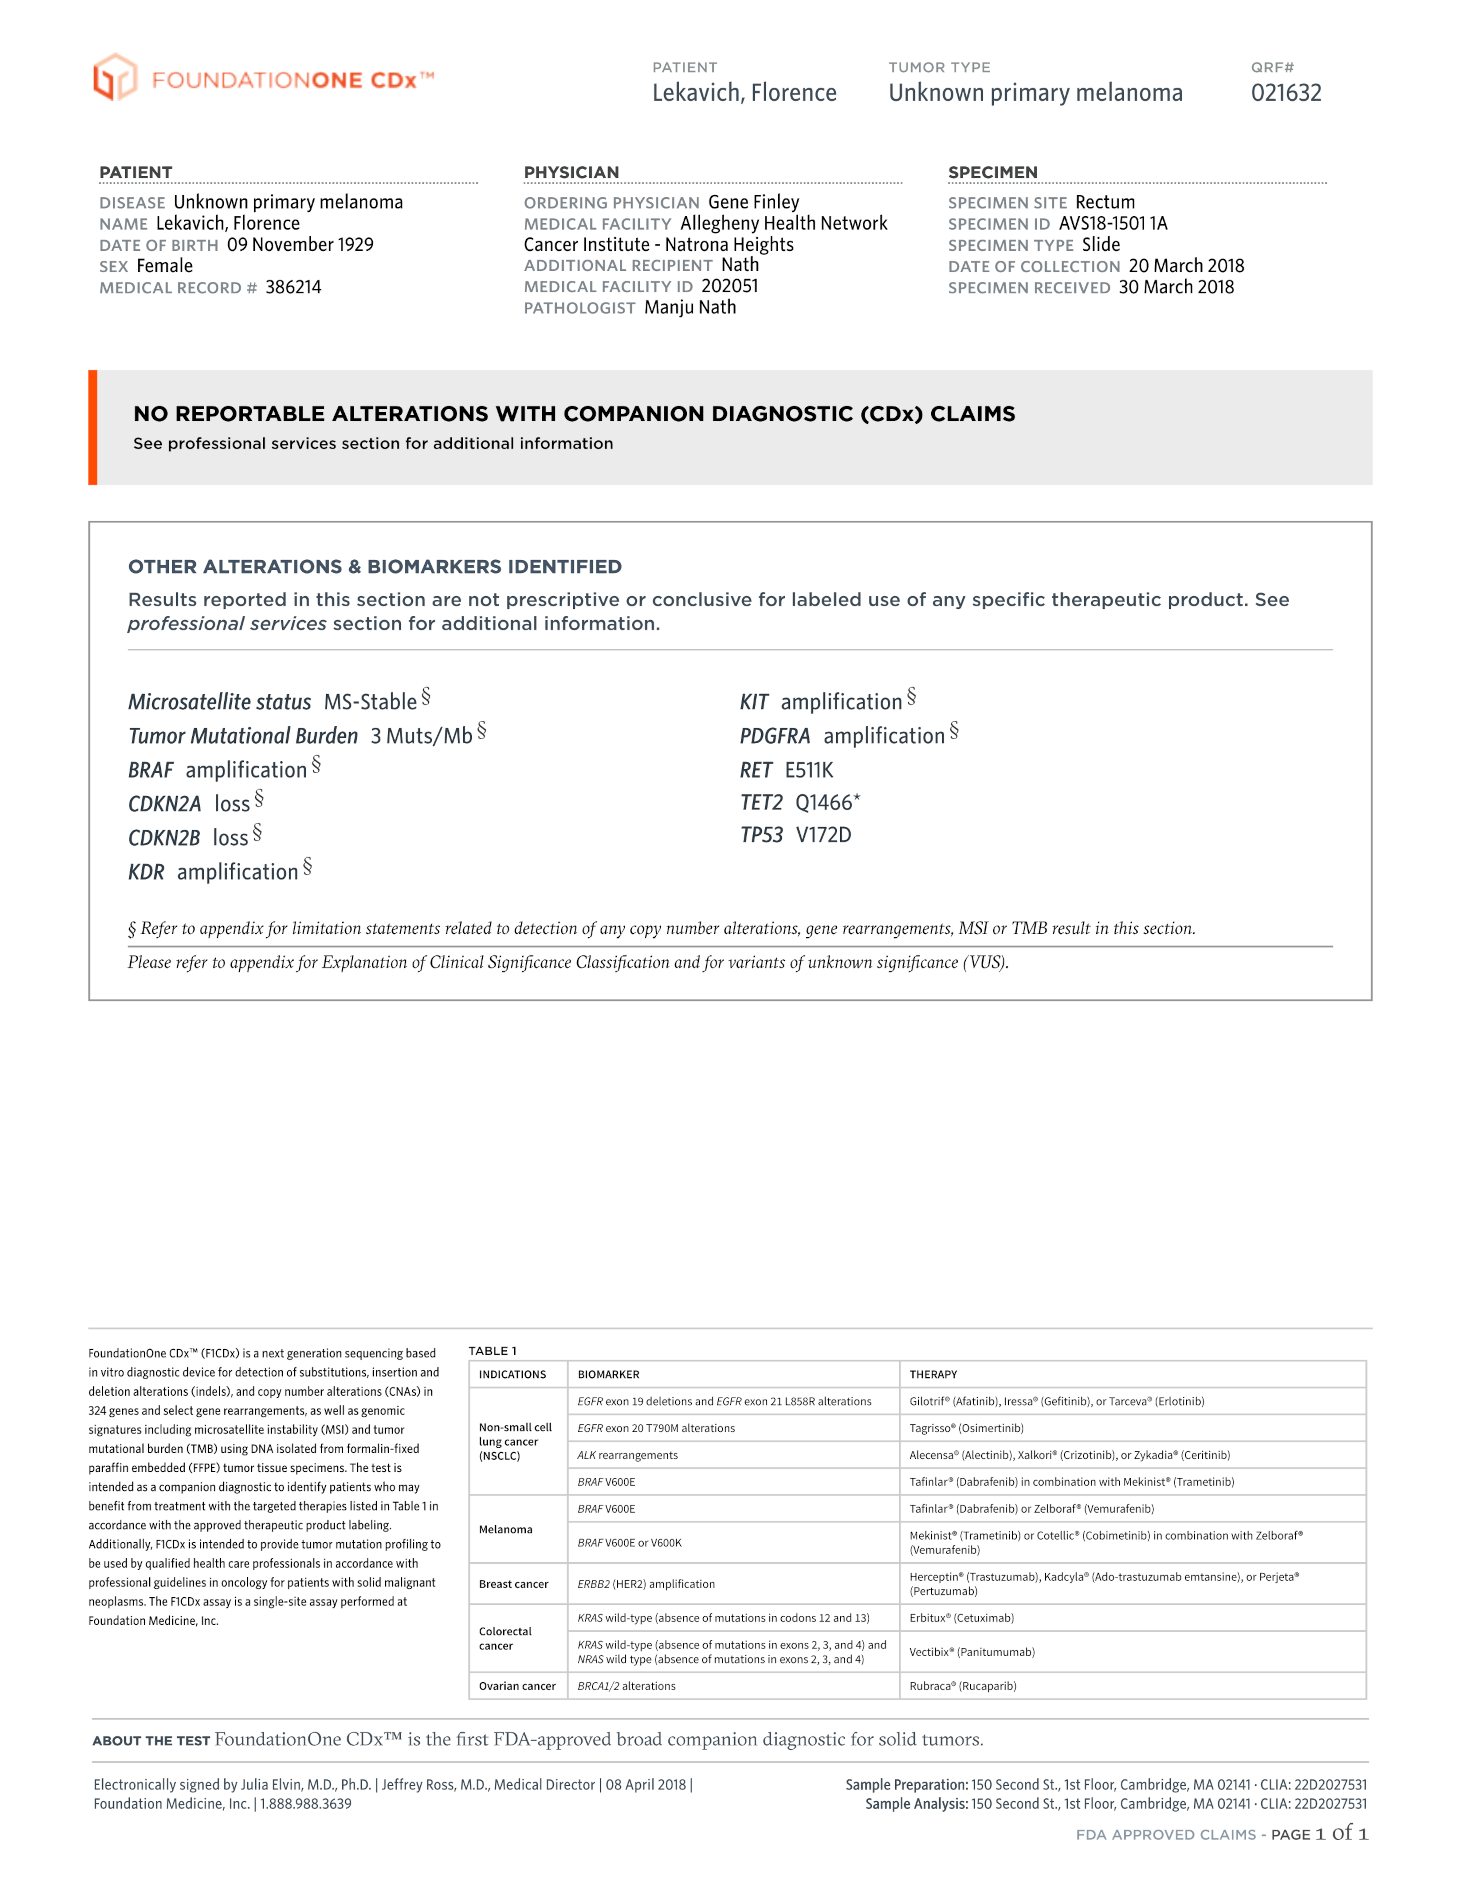

In [17]:
# Show image from file path
Image(filename='./data/genetic_report_p1.png')

In [18]:
input_data = {
    "model": "/opt/ml/model",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "url": f"data:image/jpeg;base64,{encode_file_to_base64('./data/genetic_report_p1.png')}",
                }
            ],
        },
    ],
}

result = invoke_realtime_endpoint(input_data)
output_content = result["output"]
print(output_content)


[{"text":"FOUNDATIONONE CDx","label":"other"},{"text":"PATIENT","label":"question","children":[{"text":"Lekavich, Florence","label":"answer"}]},{"text":"TUMOR TYPE","label":"question","children":[{"text":"Unknown primary melanoma","label":"answer"}]},{"text":"ORF#","label":"question","children":[{"text":"021632","label":"answer"}]},{"text":"PATIENT","label":"question","children":[{"text":"DISEASE","label":"answer","children":[{"text":"Unknown primary melanoma","label":"question","children":[{"text":"Lekavich, Florence","label":"answer"}]}]},{"text":"NAME","label":"question","children":[{"text":"Lekavich, Florence","label":"answer"}]},{"text":"DATE OF BIRTH","label":"question","children":[{"text":"09 November 1929","label":"answer"}]},{"text":"SEX","label":"question","children":[{"text":"Female","label":"answer"}]},{"text":"MEDICAL RECORD #","label":"question","children":[{"text":"386214","label":"answer"}]}]},{"text":"PHYSICIAN","label":"question","children":[{"text":"NAME","label":"an

In [19]:
import json

parsed = json.loads(output_content)
print(json.dumps(parsed, indent=2))

[
  {
    "text": "FOUNDATIONONE CDx",
    "label": "other"
  },
  {
    "text": "PATIENT",
    "label": "question",
    "children": [
      {
        "text": "Lekavich, Florence",
        "label": "answer"
      }
    ]
  },
  {
    "text": "TUMOR TYPE",
    "label": "question",
    "children": [
      {
        "text": "Unknown primary melanoma",
        "label": "answer"
      }
    ]
  },
  {
    "text": "ORF#",
    "label": "question",
    "children": [
      {
        "text": "021632",
        "label": "answer"
      }
    ]
  },
  {
    "text": "PATIENT",
    "label": "question",
    "children": [
      {
        "text": "DISEASE",
        "label": "answer",
        "children": [
          {
            "text": "Unknown primary melanoma",
            "label": "question",
            "children": [
              {
                "text": "Lekavich, Florence",
                "label": "answer"
              }
            ]
          }
        ]
      },
      {
        "text": "NAM

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.